In [20]:
import pandas as pd
import numpy as np
from scipy import stats, interpolate
import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from ipywidgets import interact

# get a list of all the colour strings in matplotlib so we can iterate through them
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colour_list = list(colors.keys())
# 9 base colours ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'aliceblue', 'antiquewhite', 'aqua'...

# Class for Handeling Each Iteration

Does all of the ugly calculations. Note, when the actions are changed, only self.action_space needs to be changed.

In [21]:
class IterationData:
    """
    A class to load in the data from each iteration to an object in a readable form for later visualisation    
    """
    def __init__(self, iteration, folder_path):

        self.training_path = folder_path + 'TrainingExamples' + str(iteration)
        self.nnet_loss_path = folder_path + 'NNetLosses' + str(iteration)
        
        # data formatting
        self.decimal_places = 3
        self.csv_rows = 5
        self.action_space = [-1, 1]
        
        # data manipulation
        self.x_threshold = 2.4
        self.theta_threshold_radians = 0.21
        
        # define a useful class for training examples, so we can access dict memebers as .'key' rather than ['key']
        class ReturnClass(dict):
            def __getattr__(self, name):
                return self[name]
        
        # just get the number of episodes (need to do this before adding episodes to the dict annoyingly)
        with open(self.training_path + '.csv', 'r', newline='') as f:
            row_count = sum(1 for row in f)
        self.episodes = int(row_count/self.csv_rows)
        
        # read in training examples data and nnet loss data
        # dict of {ep1: dataframe[2Dstate, TrueValue, PolicyValue, MCTSAction, PolicyAction, Observation], ep2: ...}
        self.episode_training_data = ReturnClass()
        self.all_iter_data = pd.DataFrame(columns=['TrueValue', 'PolicyValue', 'MCTSAction', 'PolicyAction', 'Observation', 'State2D'])
        self.state_2ds = np.load(self.training_path +'.npz')
        self.read_examples()
        self.nnet_losses = self.read_nnet_losses()
    
    def read_examples(self):
        step_counter = 0
        for episode in range(self.episodes):
            
            rows = [self.csv_rows*episode, self.csv_rows*episode+1, self.csv_rows*episode+2, self.csv_rows*episode+3, self.csv_rows*episode+4]

            # only pick out relevent rows (because others are different lengths -> can't be read)
            episode_data = pd.read_csv(self.training_path + '.csv', header=None, skiprows=lambda x: x not in rows).transpose()
            episode_data.columns = ['TrueValue', 'PolicyValue', 'MCTSAction', 'PolicyAction', 'Observation']
            episode_data.TrueValue = episode_data.TrueValue.astype(float).round(self.decimal_places)
            episode_data.PolicyValue = episode_data.PolicyValue.astype(float).round(self.decimal_places)

            # Split arrays and convert to floats
            episode_data.MCTSAction = episode_data.MCTSAction.apply(lambda x: x[1:-1].split(', '))
            episode_data.MCTSAction = episode_data.MCTSAction.apply(lambda x: [round(float(elm), self.decimal_places) for elm in x])
            
            episode_data.PolicyAction = episode_data.PolicyAction.apply(lambda x: x[1:-1].split(', '))
            episode_data.PolicyAction = episode_data.PolicyAction.apply(lambda x: [round(float(elm), self.decimal_places) for elm in x])
            
            episode_data.Observation = episode_data.Observation.apply(lambda x: x[1:-1].split())
            episode_data.Observation = episode_data.Observation.apply(lambda x: [round(float(elm), self.decimal_places) for elm in x])

            # if we want extra columns then this is the way to seperate the arr
            # print(list(zip(*dataframe.MCTSAction.values)))            
            
            # add a reference to the stated2D for each step
            episode_states = list(self.state_2ds)[step_counter:step_counter+episode_data.index[-1]+1]
            step_counter += episode_data.index[-1]+1          
            episode_data['State2D'] = episode_states
            
            # and then add the whole dataframe to the dict
            self.episode_training_data['Episode'+str(episode)] = episode_data
            self.all_iter_data = pd.concat([self.all_iter_data, episode_data], ignore_index=True)
        
    def read_nnet_losses(self):
        losses = pd.read_csv(self.nnet_loss_path + '.csv', names=['Action', 'Value', 'Total'])
        return losses
    
    def get_state_2d(self, episode, step):
        episode = 'Episode'+str(episode)
        return self.state_2ds[self.episode_training_data[episode].State2D.values[step]]
    
    def get_episode_length(self, episode):
        episode = 'Episode'+str(episode)
        return self.episode_training_data[episode].index[-1]
        
    def plot_state_2d(self, state_2d):
        # Plot MCTS action, action policy and values associated?
        fig = plt.figure()
        axes = fig.add_axes([0, 0, 1, 1])  # add an axis object to the figure
        
        # returns a colourAxisImage, that we need to map the colourbar to the figure
        mapable = axes.imshow(state_2d, extent=[-self.x_threshold, self.x_threshold, -self.theta_threshold_radians,
                                     self.theta_threshold_radians], cmap='jet', aspect='auto')
        axes.set_xlabel("X-Position")
        axes.set_ylabel("Angular Position")
        axes.set_title('The 2D State')
    
    def get_action_image(self, prob_array, axes, title='Left', vs=(0.2, 0.8)):
        
        image = axes.imshow(prob_array, vmin = vs[0], vmax=vs[1], 
                            extent=[-self.x_threshold, self.x_threshold, -self.theta_threshold_radians, self.theta_threshold_radians], 
                            cmap='jet', aspect='auto')
        axes.set_xlabel("X-Position")
        axes.set_ylabel("Angular Position")
        axes.set_title(title+' probability vs Position')
        return axes, image
    
    def plot_episode_values(self, episode, iteration, colour = 'blue', fig_axes=None):
        # extract data for values and actions
        policy_values = self.episode_training_data['Episode'+str(episode)].PolicyValue
        true_values = self.episode_training_data['Episode'+str(episode)].TrueValue
        
        # check if subplots already exist
        if fig_axes is None:
            fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(17, 7))
        else:
            fig, axes = fig_axes[0], fig_axes[1]
            
        # Value Subplot
        axes.plot(policy_values, color=colour, linestyle='--', label='Policy Values, Iter:'+str(iteration)+ ' Ep:'+str(episode))
        axes.plot(true_values, color=colour, linestyle='-', label='True Values, Iter:'+str(iteration)+ ' Ep:'+str(episode))
        axes.legend()
        axes.set_ylabel('State Value')
        
        return fig, axes
    
    def plot_episode_actions(self, episode, iteration, actions=['left'], colour = 'blue', fig_axes=None):
        
        policy_actions = self.episode_training_data['Episode'+str(episode)].PolicyAction.values
        mcts_actions = self.episode_training_data['Episode'+str(episode)].MCTSAction.values
        policy_actions = list(zip(*policy_actions))
        mcts_actions = list(zip(*mcts_actions))        

        # check if subplots already exist
        if fig_axes is None:
            fig, axes = plt.subplots(ncols=1, nrows=len(actions), figsize=(17, len(actions)*7))
        else:
            fig, axes = fig_axes[0], fig_axes[1]
        
        if len(actions) > 1:
            for idx, action in enumerate(actions):
                axes[idx].plot(policy_actions[idx], color=colour, linestyle='--', label='Policy Actions, Iter:'+str(iteration)+ ' Ep:'+str(episode))
                axes[idx].plot(mcts_actions[idx], color=colour, linestyle='-', label='MCTS Actions, Iter:'+str(iteration)+ ' Ep:'+str(episode))
                axes[idx].legend()
                axes[idx].set_ylabel(action+' probability')
                axes[idx].set_xlabel('Steps')
        else:
            action = actions[0]
            axes.plot(policy_actions[0], color=colour, linestyle='--', label='Policy Actions, Iter:'+str(iteration)+ ' Ep:'+str(episode))
            axes.plot(mcts_actions[0], color=colour, linestyle='-', label='MCTS Actions, Iter:'+str(iteration)+ ' Ep:'+str(episode))
            axes.legend()
            axes.set_ylabel(action+' probability')
            axes.set_xlabel('Steps')
            
        return fig, axes
        
    def iteration_stepwise_value_stats(self):
        plt.figure(figsize=(17, 7))
        averages = -1*np.ones((200+1, ))
        deviations = np.zeros((200+1, ))
        all_episodes = []
        # print(averages.head())
        for i in range(self.episodes):
            true_values = self.episode_training_data['Episode'+str(i)].TrueValue.values  # TrueValue or PolicyValue
            all_episodes.append(true_values)
            x = len(true_values)
            averages[0:x] += true_values
            averages[x:] += -1
            deviations[0:x] += true_values**2
            deviations[x:] += 1
        
        averages = averages/self.episodes
        deviations = np.sqrt(deviations - averages**2)/self.episodes  # to get the standard deviation
        return averages, deviations, all_episodes
    
    def calculate_action_vs_state_prob(self, policy, x_dot_fixed=0, theta_dot_fixed=0, bin_proportion=0.15):
        shape = self.get_state_2d(episode=0, step=0).shape
        
        x_dot_bin_size = bin_proportion # /self.x_threshold # either side of the value
        theta_dot_bin_size = bin_proportion # /self.theta_threshold_radians # either side of the value
        
        # only 2 actions currently
        actions_probs = np.zeros(shape, dtype=float)
        actions_counter = np.zeros(shape, dtype=float)
        
        act = 'PolicyAction'
        if not policy: act = 'MCTSAction'
        actions = list(zip(*self.all_iter_data[act].values))
        obs = list(zip(*self.all_iter_data['Observation'].values))
        state_2ds = self.all_iter_data['State2D'].values
        obs0, obs1, obs2, obs3 = np.array(obs[0]), np.array(obs[1]), np.array(obs[2]), np.array(obs[3])
        
        is_near_x_dot = (obs1 > x_dot_fixed - x_dot_bin_size) & (obs1 < x_dot_fixed + x_dot_bin_size)
        is_near_theta_dot = (obs3 > theta_dot_fixed - theta_dot_bin_size) & (obs3 < theta_dot_fixed + theta_dot_bin_size)
        filtered_left = np.array(actions[0])[is_near_x_dot & is_near_theta_dot]
        filtered_states = np.array(state_2ds)[is_near_x_dot & is_near_theta_dot]
        
        for idx, step in enumerate(filtered_states):
            state_2d = self.state_2ds[step]
            row, column = np.unravel_index(np.argmax(state_2d, axis=None), shape) # get the index of the current element
        
            actions_probs[row, column] += filtered_left[idx]
            actions_counter[row, column] += 1
            
        actions_probs = np.true_divide(actions_probs, actions_counter)        
        return actions_probs, 1-actions_probs
    
    def histogram_observations(self, normalised=True):
        
        # loop through all episodes to extract the observations
        all_observations = []
        for ep in range(self.episodes):
            all_observations.extend(self.episode_training_data['Episode'+str(ep)].Observation.values)
            
        # normalise all the observations
        if normalised:
            all_normed_observations = []
            for step in all_observations:
                obs = [step[0]/self.x_threshold,
                        step[1]/self.x_threshold,
                        step[2]/self.theta_threshold_radians,
                        step[3]/self.theta_threshold_radians,
                        ]
                all_normed_observations.append(obs)
            all_observations = all_normed_observations
        # flip the dimensions
        all_observations = list(zip(*all_observations))
        
        # Plot histograms
        fig, axes = plt.subplots(ncols=len(all_observations), nrows=1, figsize=(len(all_observations)*5, 5))
        obs_label = ['x', '$\dot{x}$', '$\\theta$', '$\dot{\\theta}$']
        axes[0].set_ylabel('Probability of Observation')
        for dim in range(len(all_observations)):
            axes[dim].hist(all_observations[dim], bins=20, density=True, color=colour_list[dim], alpha=0.9)
            if normalised:
                axes[dim].set_xlabel('Normalised '+obs_label[dim])
            else:
                axes[dim].set_xlabel(obs_label[dim])
                
    def get_max_episode(self):
        max_ep_len, max_ep = 0, 0
        for ep in range(self.episodes):
            ep_len = self.get_episode_length(ep)
            if ep_len > max_ep_len:
                max_ep_len = ep_len
                max_ep = ep
        return max_ep
            

# Class for comparing and visualising data between iterations and episodes

In [22]:
class VisualiseData:
    """
    Uses objects of IterationData, which have building-block functions associated with them to more complexly visualise
    The data from each iteration and compare iterations.
    Attribute/Data Structure:
        
        self.iter_training_data = [IterationData(0), ..., IterationData(n)]
        
        IterationData:
            self.episodes = episodes in an iteration
            self.state_2ds = USE "get_state2d()" INSTEAD... list of state_2ds for an iteration
            self.nnet_losses = Dataframe with ['Action', 'Value', 'Total'] as the column headders
            self.episode_training_data = A Dictionary of episodes with keys ['EpisodeN'] where N is an int.
                    Each episode's value is a pandas dataframe with columns:
                    
                    ['TrueValue', 'PolicyValue', 'MCTSAction', 'PolicyAction',      'Observation',      'State2D']
                      [ float,      float,         [f, f, f],     [f, f, f],  [x, xdot, theta, thetadot], 'arr_n']
        
    Building-Block Functions:
    
        plot_nnet_losses(self):
                returns: none, plots the action, value and total loss for an iteration
                
        get_state_2d(self, episode, step):
                returns: the state 2D for the episode and step (since it it stored outside the dataframe)
        
        get_episode_length(self, episode):
                returns: the episode length for an episode in an iteration
    
        calculate_action_vs_state_prob(self, x_dot_fixed=0, theta_dot_fixed=0, bin_proportion=0.5):
                returns: 3 2d numpy arrays of p(a = ['left', 'do_nothing', 'right'] | xdot, thetadot, bin_size)
        
        iteration_stepwise_value_stats(self, plot_all_eps=False):
                returns: stepwise Value mean and std over all episodes in an iteration (optionally plot all episodes from iter)
                
        plot_episode_values(self, episode, colour = 'blue', fig_axes=None):
                returns: fig, axes so that we can plot more episodes on top, or plot from other iters
                
        plot_episode_actions(self, episode, actions=['left', 'do_nothing', 'right'], colour = 'blue', fig_axes=None):
                returns: fig, axes so that we can plot more episodes on top, or plot from other iters 
                
        plot_state_2d(self, state_2d):
                returns: plots the 2d state
                
        def get_action_image(self, prob_array, fig_ax, title='Left', vs=(0.2,0.5)):
                returns: fig, axes, image... takes an axes and plots the action-prob for that axis. image is for colourbar
                
        histogram_observations(self):
                returns: plots 4 histograms of the normalised observations
    """
    
    def __init__(self, data_set_path, iters='all'):
        self.folder_path = data_set_path
        
        self.action_names ={-1: 'Left', 0:'Nothing', 1: 'Right'}
        
        self.iter_training_data = []
        if iters == 'all':
            self.iterations = 0
            while True:
                try: self.iter_training_data.append(IterationData(self.iterations, self.folder_path))
                except: break
                self.iterations += 1
        else:
            assert isinstance(iters, list)
            for itr in iters:
                self.iter_training_data.append(IterationData(itr, self.folder_path))
            self.iterations = len(self.iter_training_data)
            
        print("There are ", self.iterations, " iterations stored in self.iterations")
            
    def plot_iter_values(self, iters=[0, 1, 2], plot_stds=False, plot_all_eps=False):
        assert all(i < self.iterations for i in iters), "Some iterations are not valid!"
        
        fig = plt.figure(figsize=(17, 7))
        axes = fig.add_axes([0, 0, 1, 1])
        axes.set_xlabel('Steps')
        axes.set_ylabel('Average Value')
        axes.set_ylim([-1, 0])
        for itr in iters:
            means, std, all_eps = self.iter_training_data[itr].iteration_stepwise_value_stats()
            
            axes.plot(means, linestyle='-', color=colour_list[itr], label='Itr:'+str(itr)+' Average Episode Value')
            if plot_stds:
                axes.plot(means+std, linestyle='--', color=colour_list[itr], label=None)
                axes.plot(means-std, linestyle='--', color=colour_list[itr], label=None)
            if plot_all_eps:
                for i in range(self.iter_training_data[itr].episodes):
                    axes.plot(all_eps[i], linestyle=':', label=None)
                    
            axes.legend()
            
    def plot_iter_losses(self, iters=[0, 1, 2]):
        assert all(i < self.iterations for i in iters), "Some iterations are not valid!"
        
        fig = plt.figure(figsize=(17, 7))
        axes = fig.add_axes([0, 0, 1, 1])
        
        axes.set_xlabel('Batches (size 8)')
        axes.set_ylabel('Loss')
        
        for itr in iters:
            axes.plot(self.iter_training_data[itr].nnet_losses, label=['Itr '+str(itr)+' Action', 'Itr '+str(itr)+'Value', 'Itr '+str(itr)+'Total'])    
            axes.legend()
    
    def plot_observation_histograms(self, iters=[0, 1, 2], normed=True):
        for itr in iters:
            self.iter_training_data[itr].histogram_observations(normed)
            
    def plot_values_vs_steps(self, iters=[0, 1, 2], episodes='longest'):
        # fig, ax = te0.plot_episode(episode=3, colour='blue')
        
        max_eps = []
        for itr in iters:
            if episodes == 'longest':
                max_eps.append(self.iter_training_data[itr].get_max_episode())
            if isinstance(episodes, list):
                pass
        
        # plot those episodes
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(17, 7))
        for idx, itr in enumerate(iters):
            fig, ax = self.iter_training_data[itr].plot_episode_values(max_eps[idx], itr, colour_list[idx], (fig, ax))
                                                                  
    def plot_actions_vs_steps(self, iters=[0, 1, 2], episodes='longest', actions=['left']):
        max_eps = []
        for itr in iters:
            if episodes == 'longest':
                max_eps.append(self.iter_training_data[itr].get_max_episode())
            if isinstance(episodes, list):
                pass
        # plot those episodes
        fig, ax = plt.subplots(ncols=1, nrows=len(actions), figsize=(17, len(actions)*7))
        for idx, itr in enumerate(iters):
            fig, ax = self.iter_training_data[itr].plot_episode_actions(max_eps[idx], itr, actions, colour_list[idx], (fig, ax))
            
    def plot_action_vs_state(self, iters=[0, 1, 2], policy=True, x_dot_fixed=0, theta_dot_fixed=0, bin_prop=0.05, colourbar_lims=(0, 1)):
        assert all(i < self.iterations for i in iters), "Some iterations are not valid!"

        for itr in iters:
            action_probs = self.iter_training_data[itr].calculate_action_vs_state_prob(policy, x_dot_fixed, theta_dot_fixed, bin_prop)

            # Plot the things
            fig, axes = plt.subplots(ncols=len(action_probs), nrows=1, figsize=(17, 5), sharey=True)
            for act_idx, action in enumerate(self.iter_training_data[0].action_space):
                ax, im = self.iter_training_data[itr].get_action_image(action_probs[act_idx], axes[act_idx], self.action_names[action], vs=colourbar_lims)

            fig.subplots_adjust(right=0.8)
            cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
            fig.colorbar(im, cax=cbar_ax)        
            
    def vs_state_3d(self, act_val=False, itr=0, angle=45, var_state=3, fixed_state=0, binsize=0.15):
        
        if act_val==0: 
            p_str = 'PolicyAction'
            cmap = 'viridis'
            ttl = ', Policy Actions '
            colour_ttl = 'Left Probability'
        if act_val==1: 
            p_str = 'MCTSAction'
            cmap = 'plasma'
            ttl = ', MCTS Actions '
            colour_ttl = 'Left Probability'
        if act_val==2: 
            p_str = 'PolicyValue'
            cmap = 'viridis'
            ttl = ', Policy Value '
            colour_ttl = 'Value'
        if act_val==3: 
            p_str = 'TrueValue'
            cmap = 'plasma'
            ttl = ', True Value '
            colour_ttl = 'Value'
        try:    
            action = list(zip(*self.iter_training_data[itr].all_iter_data[p_str].values))[0]
        except:
            action = self.iter_training_data[itr].all_iter_data[p_str].values
        obs = list(zip(*self.iter_training_data[itr].all_iter_data['Observation'].values))
        
        # set up the plot    
        fig = plt.figure(figsize=(17, 14))
        ax = fig.add_subplot(111, projection='3d')
        if var_state == 1:
            fixed_obs = np.array(obs[3])
            ax.set_ylabel('$\dot{x}$, x-velocity (m/s)');
            ax.set_title('Iteration '+str(itr)+ttl+'with $\dot{\\theta}$ = '+str(fixed_state)+'$\pm$'+str(binsize)+'rad/s')
        else:
            fixed_obs = np.array(obs[1])
            ax.set_ylabel('$\dot{\\theta}$, angular velocity (rad/s)')
            ax.set_title('Iteration '+str(itr)+ttl+'with $\dot{x}$ = '+str(fixed_state)+'$\pm$'+str(binsize)+'m/s')
            
        x_min, x_max = min((obs[0]))-1, max(obs[0])
        fixed_min, fixed_max = min(fixed_obs)-1, max(fixed_obs) 
        theta_min, theta_max = min(obs[2])-0.25, max(obs[2])
            
            
        # extract the relavent points    
        is_near_filter = (fixed_obs > fixed_state-binsize) & (fixed_obs < fixed_state+binsize)
        x, y, z = np.array(obs[0])[is_near_filter], np.array(obs[var_state])[is_near_filter], np.array(obs[2])[is_near_filter]
        density = np.array(action)[is_near_filter]   
        
        # plot the main plot
        ax.scatter(x, y, z, c=density, alpha=1, cmap=cmap)
        ax.set_xlabel('x position (m)'); ax.set_zlabel('$\\theta$ position (rad)')
        
        # and add the 2d compressed versions
        
        ax.scatter(x, y, theta_min, zdir='z', c=density, s=5, alpha=0.5, cmap=cmap)
        ax.scatter(x_min, y, z, zdir='z', c=density, s=5, alpha=0.5, cmap=cmap)
        ax.scatter(x, fixed_min, z, zdir='z', c=density, s=5, alpha=0.5, cmap=cmap)
        
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(fixed_min, fixed_max)
        ax.set_zlim(theta_min, theta_max)
        

        # sort out the colourbar
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        mappable = cm.ScalarMappable(cmap=cmap); mappable.set_array(density); mappable.set_clim(min(action), max(action))
        plt.colorbar(mappable, cax=cbar_ax)
        cbar_ax.set_title(colour_ttl)

        
        ax.view_init(25, angle)
        plt.show()



# Plot Things

In [31]:
# folder = os.path.join('..\ArchivedData', 'WhyNNETdoesntworkRes', '3Actions\\')
# folder = os.path.join('..\ArchivedData', 'WhyNNETdoesntworkConv', '3Actions\\')
folder = r'Data\\'
# folder = os.path.join('..\ArchivedData', '40sims\\')
v = VisualiseData(folder, iters=[0, 1, 2, 3, 4]) #, 1, 2, 3, 4, 5, 6])
v.iter_training_data[0].episode_training_data['Episode0'].head()

There are  5  iterations stored in self.iterations


,TrueValue,PolicyValue,MCTSAction,PolicyAction,Observation,State2D
0,-0.133,-0.506,"[0.517, 0.483]","[0.508, 0.492]","[0.881, -1.067, 0.1, 0.235]",arr_0
1,-0.161,-0.505,"[0.512, 0.488]","[0.508, 0.492]","[0.86, -0.873, 0.105, -0.024]",arr_1
2,-0.201,-0.506,"[0.51, 0.49]","[0.508, 0.492]","[0.842, -1.07, 0.105, 0.299]",arr_2
3,-0.236,-0.507,"[0.418, 0.582]","[0.509, 0.491]","[0.821, -1.266, 0.111, 0.623]",arr_3
4,-0.230,-0.506,"[0.308, 0.692]","[0.509, 0.491]","[0.796, -1.463, 0.123, 0.949]",arr_4


In [24]:
v.iter_training_data[0].all_iter_data.tail()

,TrueValue,PolicyValue,MCTSAction,PolicyAction,Observation,State2D
1776,-0.398,-0.508,"[0.291, 0.709]","[0.511, 0.489]","[-0.922, -1.016, 0.132, 0.881]",arr_1776
1777,-0.455,-0.508,"[0.444, 0.556]","[0.511, 0.489]","[-0.942, -1.212, 0.15, 1.212]",arr_1777
1778,-0.560,-0.508,"[0.444, 0.556]","[0.511, 0.489]","[-0.966, -1.019, 0.174, 0.97]",arr_1778
1779,-0.744,-0.508,"[0.508, 0.492]","[0.511, 0.489]","[-0.987, -0.827, 0.193, 0.737]",arr_1779
1780,-0.977,-0.508,"[0.508, 0.492]","[0.511, 0.489]","[-1.003, -1.024, 0.208, 1.083]",arr_1780


In [25]:
interact(v.vs_state_3d, act_val=(0, 3, 1), itr=(0 ,6, 1), angle=(0, 180, 5), var_state=(1, 3, 2), fixed_state=(-3, 3, 0.1), binsize=(0.05, 2, 0.05))

interactive(children=(IntSlider(value=0, description='act_val', max=3), IntSlider(value=0, description='itr', …

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

C:\Users\Alex\Miniconda3\lib\site-packages\ipykernel_launcher.py:202: RuntimeWarning: invalid value encountered in true_divide


KeyboardInterrupt: 

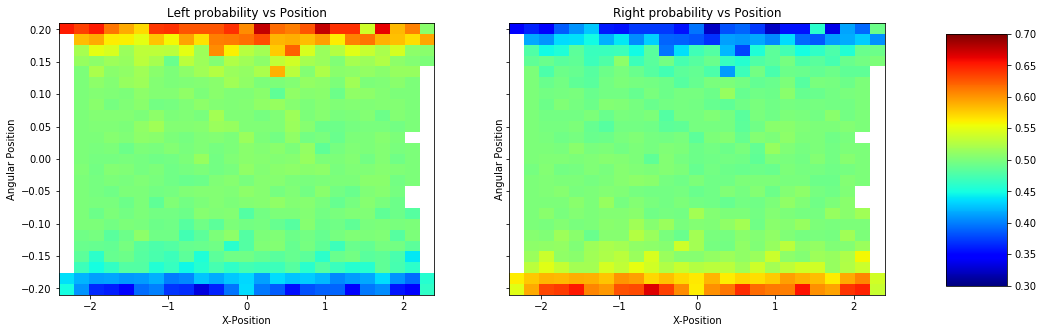

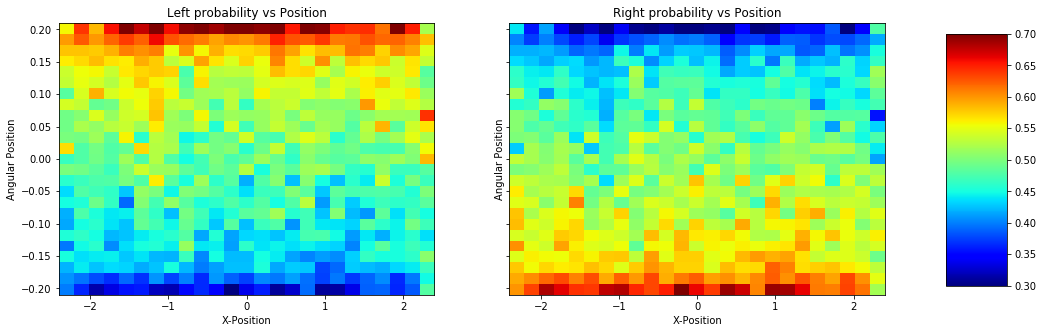

In [23]:
iters = [0, 1, 2, 3, 4, 5, 6]
v.plot_action_vs_state(iters, policy=False, x_dot_fixed=0, theta_dot_fixed=0, bin_prop=0.1, colourbar_lims=(0.3, 0.7))

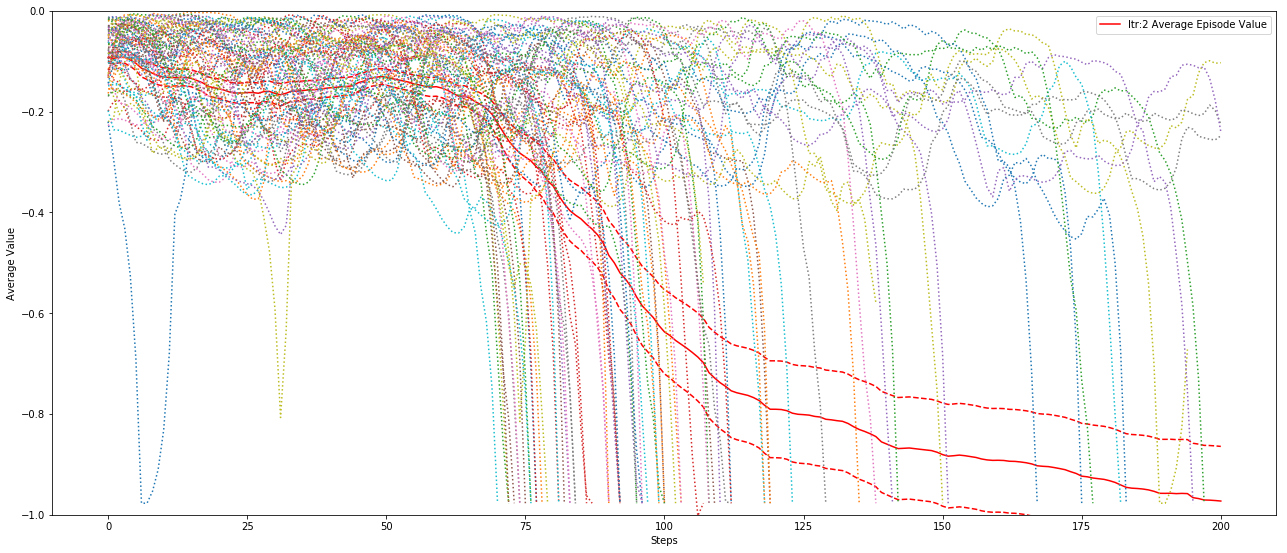

<Figure size 1224x504 with 0 Axes>

In [26]:
iters = [2]
v.plot_iter_values(iters, plot_stds=True, plot_all_eps=True)

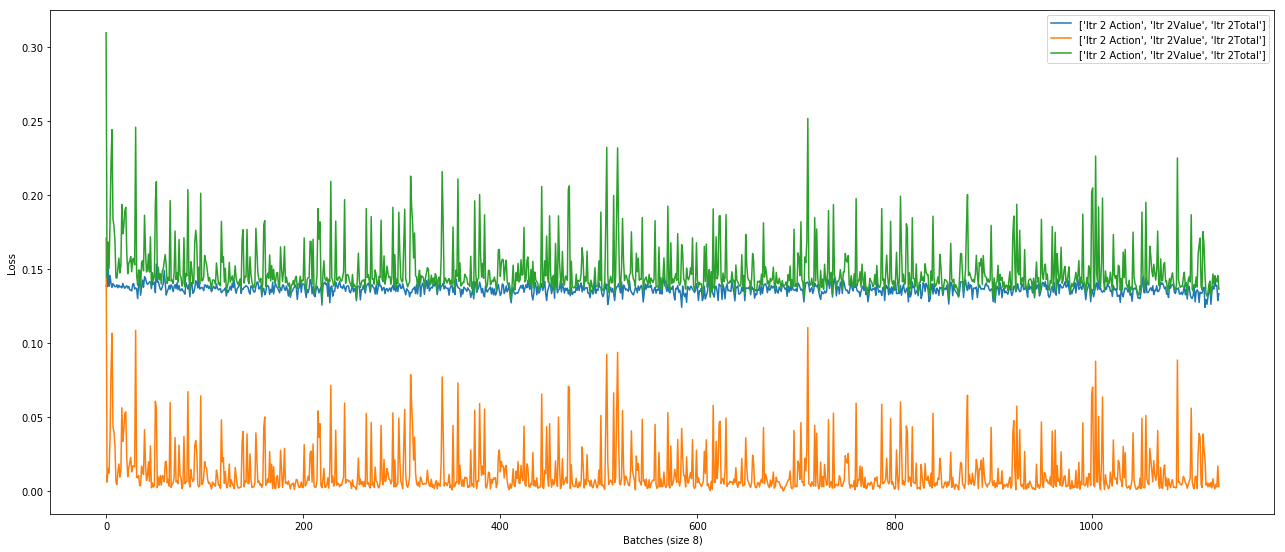

In [27]:
iters = [2]
v.plot_iter_losses(iters)

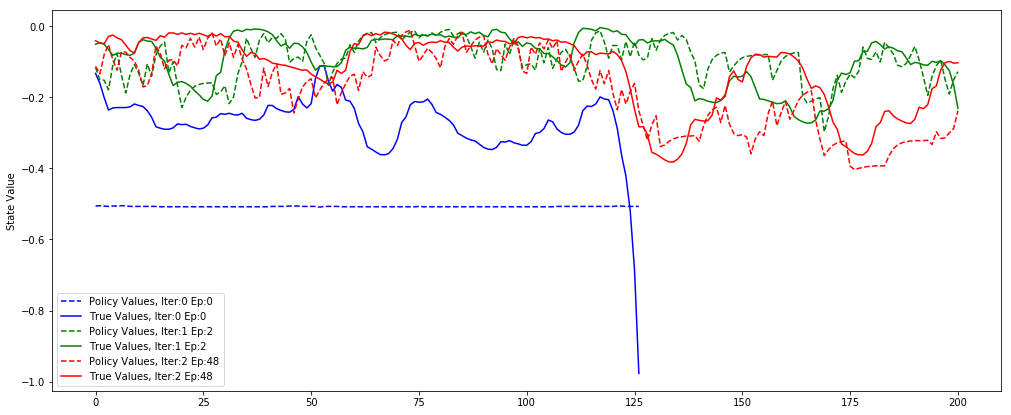

In [29]:
v.plot_values_vs_steps(iters=[0, 1, 2], episodes='longest') # need to update so episodes can take any list

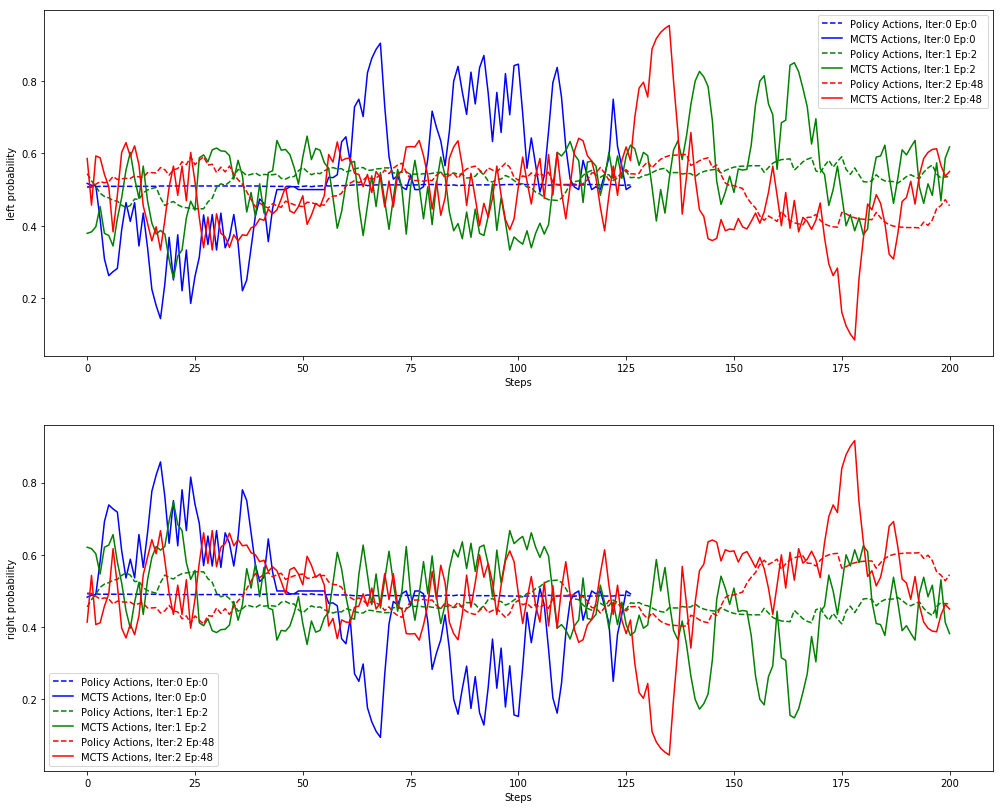

In [30]:
v.plot_actions_vs_steps(iters=[0, 1, 2], episodes='longest', actions=['left', 'right'])

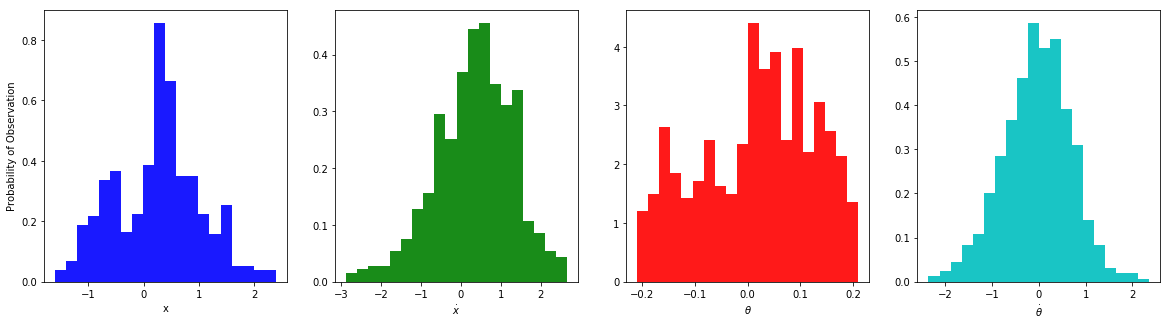

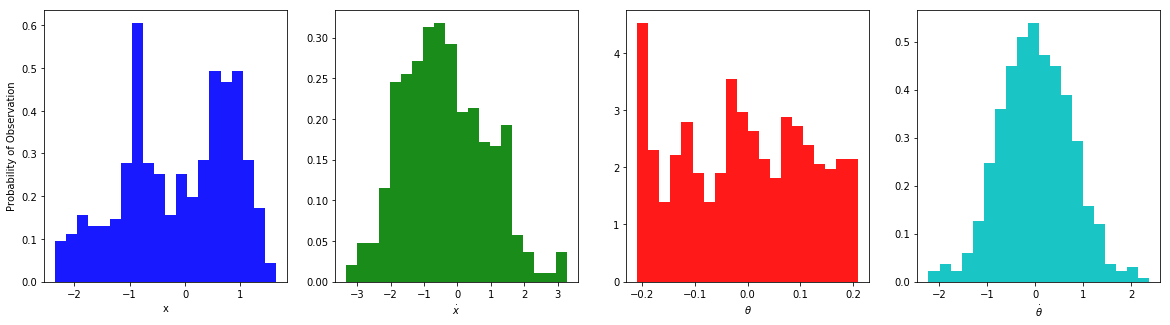

In [128]:
v.plot_observation_histograms(iters=[0, 1], normed=False)